# Bundled electron insert factors modelling example

## Interface description

This is a [jupyter notebook](http://jupyter.org). It contains both text (like this) and code (the first cell containing code is [at this link](#Importing-all-the-packages-to-be-used-in-this-notebook)). Code can be run by clicking the relevant cell and then pressing `Shift + Enter`. This notebook has been designed so that the cells are to be run one after the other. You should observe the output of each cell before continuing onto the next cell.


## Demo this notebook online
Go to http://simonbiggs.net/electrondemo to use an online version of this notebook. This can be quickly trialed with your data to determine whether or not it is worth your while.

Do note that this demo is using a free server available from http://mybinder.org. As such expect it to run relatively slow and at times not be avaialable.


## Project Description
The code here provided is for the modelling of the portion of the electron output factor that is dependent on the shape of the shielding insert mounted within the applicator. This allows modelling insert factors using only the measured factors already available at a centre. Should all outliers be removed from the data set the user might expect as low as 0.5% standard uncertainty for factor prediction with as little as 8 data points.

The paper outlining this method is the following:
 
 > Biggs, S., Sobolewski, M., Murry, R., & Kenny, J. (2015). Spline modelling electron insert factors using routine measurements. *Physica Medica: European Journal of Medical Physics*, Volume 32, Issue 1, 255 - 259. [doi:10.1016/j.ejmp.2015.11.002](http://dx.doi.org/10.1016/j.ejmp.2015.11.002). 

If you have any issues please don't hesitate to contact me at [mail@simonbiggs.net](mailto:mail@simonbiggs.net). I am more than happy to help or to receive any feedback. 

## Disclaimer

Any use of the code accepts the [AGPL3+ license](../edit/LICENSE) which includes no warranty that this code is fit for a particular purpose. Attempts have been made to make the code transparent and it is recommended that an experienced python programmer and physicist who understands the procedure outlined in the paper and the requirements of your centre identifies whether or not this method and code is fit for your use.


## Running this notebook on your local machine
 * Download and install the relevant Anaconda Python 3.5 install from [continuum.io/downloads](https://www.continuum.io/downloads).
 * Download the zip file containing this notebook and all relevant files from http://simonbiggs.net/electronbundle.
 * Extract the zip file.
 * Run `install_required_modules.bat` to install the modules required to run this notebook.
 * Open the shortcut `open_notebook.lnk` to boot the jupyter notebook server.
 * Open the `electroninserts_notebook.ipynb` file by either clicking on the file within the jupyter dashboard or going to http://localhost:8888/notebooks/electroninserts_notebook.ipynb (this link will only work once the server is running).

## Importing all the packages to be used in this notebook

The following cell imports all the modules and functions required. Of note are `lines 18 - 20` which import the custom `electroninserts` functions. These custom functions are located within [electroninserts.py](../edit/electroninserts.py) which can be perused to ensure it is running as you would expect.

In [1]:
import dicom

from glob import glob

import zipfile
import time
import datetime
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, Markdown

from bokeh.io import output_notebook, output_file, reset_output

from electroninserts import (
    parameterise_single_insert, display_parameterisation,
    create_report_from_pandas)

print("All modules and functions successfully imported.")

All modules and functions successfully imported.


## Parameterising shapes

Three options to parameterise shapes are given below; from raw coordinates, from an RT-DICOM file, or from a Monaco&reg; 5.10 `tel.1` file.

There is also a placeholder for importing directly from Eclipse&trade;. Please [let me know](mailto:mail@simonbiggs.net)  if someone with access to Eclipse&trade; achieves this.

### From coordinates

Width = 6.53 cm
Length = 10.99 cm


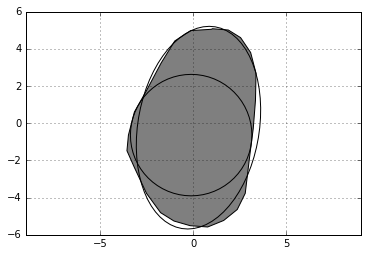

In [2]:
x = [0.99, -0.14, -1.0, -1.73, -2.56, -3.17, -3.49, -3.57, -3.17, -2.52, -1.76,
    -1.04, -0.17, 0.77, 1.63, 2.36, 2.79, 2.91, 3.04, 3.22, 3.34, 3.37, 3.08, 2.54,
    1.88, 1.02, 0.99]
y = [5.05, 4.98, 4.42, 3.24, 1.68, 0.6, -0.64, -1.48, -2.38, -3.77, -4.81,
    -5.26, -5.51, -5.58, -5.23, -4.64, -3.77, -2.77, -1.68, -0.29, 1.23, 2.68, 3.8,
    4.6, 5.01, 5.08, 5.05]

width, length, poi = parameterise_single_insert(x, y)
print("Width = {0:0.2f} cm\nLength = {1:0.2f} cm".format(width, length))

display_parameterisation(x, y, width, length, poi)

### From RT-DICOM

If you are using the online version of this notebook you will likely want to deidentify your dicom files. http://www.dicompyler.com/ can be used to do this however I am not in a position to guarantee it will do this adequately. You need to check this yourself.

To upload the dicom file go to [notebook home](../tree) and click the "upload button" located at the top right of the dashboard.

Applicator = 10X10 (identifier name)
Energy = 12.0 (nominal)
SSD = 1001.0 (dicom units)

Width = 4.11 cm
Length = 9.52 cm


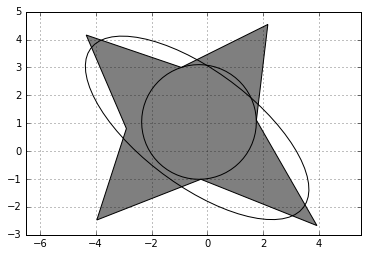

In [3]:
# Change this name to match the dicom file located in the same directory
# as this notebook.
dicom_filename = "star.dcm"  

dcm = dicom.read_file(dicom_filename, force=True)
applicator_string = dcm.BeamSequence[0].ApplicatorSequence[0].ApplicatorID
energy_string = dcm.BeamSequence[0].ControlPointSequence[0].NominalBeamEnergy
ssd_string = dcm.BeamSequence[0].ControlPointSequence[0].SourceToSurfaceDistance

print("Applicator = {} (identifier name)".format(applicator_string))
print("Energy = {} (nominal)".format(energy_string))
print("SSD = {} (dicom units)\n".format(ssd_string))

block_data = np.array(dcm.BeamSequence[0].BlockSequence[0].BlockData)
x = np.array(block_data[0::2]).astype(float)/10
y = np.array(block_data[1::2]).astype(float)/10

width, length, poi = parameterise_single_insert(x, y)
print("Width = {0:0.2f} cm".format(width))
print("Length = {0:0.2f} cm".format(length))

display_parameterisation(x, y, width, length, poi)

### Directly from Monaco&reg; 5.10 server

The following code is an example of what can be used to automatically pull and parameterise shapes from the server based off of patient ID. For use in other centres it will need adjustment.

In [4]:
## Find a tel file on server
# patientID = 'not_telling'
# string_search_pattern = r'\\MONACODA\FocalData\YourFolder\1~Clinical\*{}\plan\*\*tel.1'.format(patientID)
# filepath_list = glob(string_search_pattern)
# print(filepath_list)

In [5]:
telfilepath = "example_monaco510_telfile"
electronmodel_regex = "YourMachineName - \d+MeV"  # \d+ stands for any positive integer

with open(telfilepath, "r") as file:
    telfilecontents = np.array(file.read().splitlines())

electronmodel_index = []
for i, item in enumerate(telfilecontents):
    if re.search(electronmodel_regex, item):
        electronmodel_index += [i]

print("Located applicator and energy strings for plans within telfile:")
applicator_tel_string = [
    telfilecontents[i+12]  # applicator string is located 12 lines below electron model name
    for i in electronmodel_index]
print(applicator_tel_string)

energy_tel_string = [
    telfilecontents[i-1]  # energy string is located 1 line before electron model name
    for i in electronmodel_index]
print(energy_tel_string)

Located applicator and energy strings for plans within telfile:
['14X14']
['15 MeV']


Applicator = 14X14
Energy = 15 MeV

Width = 8.76 cm
Length = 14.00 cm


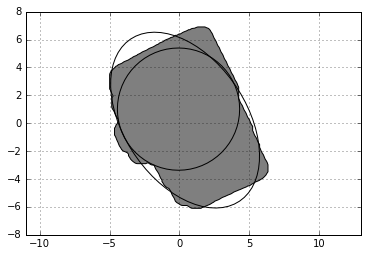

In [6]:
for i, index in enumerate(electronmodel_index):
    print("Applicator = {}".format(applicator_tel_string[i]))
    print("Energy = {}\n".format(energy_tel_string[i]))
    
    insert_inital_range = telfilecontents[
        index + 51::]  # coords start 51 lines after electron model name
    insert_stop = np.where(
        insert_inital_range=='0')[0][0]  # coords stop right before a line containing 0
    
    insert_coords_string = insert_inital_range[:insert_stop]
    insert_coords = np.fromstring(','.join(insert_coords_string), sep=',')
    x = insert_coords[0::2]/10
    y = insert_coords[1::2]/10
    
    width, length, poi = parameterise_single_insert(x, y)
    print("Width = {0:0.2f} cm".format(width))
    print("Length = {0:0.2f} cm".format(length))
    display_parameterisation(x, y, width, length, poi)

### Direct from Eclipse&trade; server

*Not yet implimented. If someone achieves this please contact me at [mail@simonbiggs.net](mailto:mail@simonbiggs.net) or create a pull request over at https://github.com/SimonBiggs/electroninserts_bundle*

## Recording and loading the data
The following cell creates a csv file which contains all the measured data. This file can be viewed at [example_data.csv](../edit/example_data.csv).

You can either write your own contents into the cell, or you can drag and drop with windows explorer a csv file into the cell.

In [7]:
%%writefile example_data.csv
label,width,length,energy,applicator,ssd,factor
Simon 3cm circle,3.15,3.16,12,10,100,0.9294
Simon 3x5cm oval,3.16,5.25,12,10,100,0.9346
Simon 3x13cm oval,3.17,13.64,12,10,100,0.9533
Simon 3x6.5cm oval,3.17,6.83,12,10,100,0.9488
Simon 3x9cm oval,3.17,9.43,12,10,100,0.9488
Simon #57 cutout,3.66,5.04,12,10,100,0.9434
Simon #112 cutout,3.71,4.36,12,10,100,0.9488
Simon 4cm circle,4.2,4.21,12,10,100,0.956
Simon 4x10cm oval,4.21,10.51,12,10,100,0.9709
Simon 4x13cm oval,4.21,13.65,12,10,100,0.9756
Simon 4x6.5cm oval,4.21,6.82,12,10,100,0.9606
Simon 4x8cm oval,4.21,8.41,12,10,100,0.9709
Simon #20 cutout,4.38,5.47,12,10,100,0.9634
P10,4.48,7.29,12,10,100,0.9606
Simon #14 cutout,4.59,5.67,12,10,100,0.9588
Simon #3 cutout,4.59,6.54,12,10,100,0.9681
Simon #38 cutout,4.67,6.28,12,10,100,0.9737
Simon #22 cutout,5.21,11.4,12,10,100,0.9881
Simon 5cm circle,5.25,5.26,12,10,100,0.9709
Simon 5x10cm oval,5.26,10.52,12,10,100,0.9881
Simon 5x13cm oval,5.26,13.66,12,10,100,0.9872
Simon 5x8cm oval,5.26,8.41,12,10,100,0.9833
Simon #104 cutout,5.34,9.64,12,10,100,0.993
P40,5.43,11.02,12,10,100,0.9872
Simon #19 cutout,5.72,11.6,12,10,100,0.999
Simon #83 cutout,5.86,8.62,12,10,100,0.9891
Simon #58 cutout,6,7.98,12,10,100,0.9911
P3,6.04,9.22,12,10,100,0.999
Simon #33 cutout,6.08,6.64,12,10,100,0.993
Simon 6cm circle,6.3,6.33,12,10,100,0.9862
Simon #43 cutout,6.31,8.24,12,10,100,0.9921
Simon #82 cutout,6.41,8.69,12,10,100,0.999
Simon #16 cutout,6.53,10.99,12,10,100,1
Simon #109 cutout,6.54,8.41,12,10,100,0.993
Simon #106 cutout,6.64,9.81,12,10,100,0.999
Simon #34 cutout,6.78,10.98,12,10,100,1.007
P22,6.9,10.25,12,10,100,0.999
Simon #41 cutout,7.08,10.77,12,10,100,1.005
Simon #6 cutout,7.18,11.27,12,10,100,0.999
P38_1,7.21,9.03,12,10,100,1.0101
Simon 7cm circle,7.36,7.37,12,10,100,1.003
Simon #73 cutout,7.56,10.05,12,10,100,1.004
P12_1,7.6,10.26,12,10,100,1.0142
Simon #70 cutout,7.64,8.99,12,10,100,1.003
Simon #18 cutout,7.82,10.85,12,10,100,1.002
Simon #32 cutout,8.06,11.85,12,10,100,1.007
Simon 8cm circle,8.4,8.42,12,10,100,1.007
Simon 9cm circle,9.45,9.47,12,10,100,1.0081
Simon 5cm_15MeV,4.99,5,15,10,100,0.9747
P36_2,5.07,9.15,15,10,100,0.9911
Simon 5.3x12.5cm_15MeV,5.26,12.45,15,10,100,0.9921
Simon 6.1cm_15MeV,6.09,6.1,15,10,100,0.9794
Simon 6.7x12cm_15MeV,6.76,12,15,10,100,0.999
P5_2,6.97,9.79,15,10,100,0.996
Simon 7.25cm_15MeV,7.23,7.26,15,10,100,1.003
P28,7.4,9.25,15,10,100,1
P37_1,7.73,9.66,15,10,100,1.005
Simon 8.3cm_15MeV,8.28,8.3,15,10,100,1.005
Simon 8.5x10.9cm_15MeV,8.5,10.85,15,10,100,1.005
Simon 9.5cm_15MeV,9.49,9.5,15,10,100,1.0091
P31_1,4.9,9.4,18,10,100,0.9911
P36_1,4.9,9.4,18,10,100,0.994
Simon 5cm_18MeV,4.99,5,18,10,100,0.9823
Simon 5.3x12.5cm_18MeV,5.26,12.45,18,10,100,0.995
Simon 6.1cm_18MeV,6.09,6.1,18,10,100,0.9881
P37_4,6.67,9.28,18,10,100,1.0081
Simon 6.7x12cm_18MeV,6.76,12,18,10,100,0.999
P12_2,6.83,9.19,18,10,100,1.005
P13,7.1,8.79,18,10,100,0.997
Simon 7.25cm_18MeV,7.23,7.26,18,10,100,1.001
Simon 8.3cm_18MeV,8.28,8.3,18,10,100,1.003
Simon 8.5x10.9cm_18MeV,8.5,10.85,18,10,100,1.004
P42,9.14,11.32,18,10,100,0.998
Simon 9.5cm_18MeV,9.49,9.5,18,10,100,1.0081
P62,3.99,6.51,6,10,100,0.9643
Simon 5cm_6MeV,4.99,5,6,10,100,0.9766
Simon 5.3x12.5cm_6MeV,5.26,12.45,6,10,100,0.996
P7,5.69,7.58,6,10,100,0.995
Simon 6.1cm_6MeV,6.09,6.1,6,10,100,0.9901
P24,6.47,8.25,6,10,100,0.995
Simon 6.7x12cm_6MeV,6.76,12,6,10,100,0.998
Simon 7.25cm_6MeV,7.23,7.26,6,10,100,1.007
P35_2,7.43,10.3,6,10,100,0.994
Simon 8.3cm_6MeV,8.28,8.3,6,10,100,1.006
P6,8.5,10.73,6,10,100,0.999
Simon 8.5x10.9cm_6MeV,8.5,10.85,6,10,100,1.003
Simon 9.5cm_6MeV,9.49,9.5,6,10,100,1.005
P46,4.37,6.21,9,10,100,0.9606
Simon 5cm_9MeV,4.99,5,9,10,100,0.9588
P53,5.09,6.32,9,10,100,0.9756
Simon 5.3x12.5cm_9MeV,5.26,12.45,9,10,100,0.9901
P25,5.38,8.23,9,10,100,0.9852
P8,5.64,6.96,9,10,100,0.9775
Simon 6.1cm_9MeV,6.09,6.1,9,10,100,0.9823
P34_3,6.72,10.23,9,10,100,0.997
Simon 6.7x12cm_9MeV,6.76,12,9,10,100,1
Simon 7.25cm_9MeV,7.23,7.26,9,10,100,1.005
Simon 8.3cm_9MeV,8.28,8.3,9,10,100,1.004
P34_2,8.37,10.6,9,10,100,0.997
Simon 8.5x10.9cm_9MeV,8.5,10.85,9,10,100,1.005
P17,8.6,9.81,9,10,100,1.0111
Simon 9.5cm_9MeV,9.49,9.5,9,10,100,1.007
P61,4.69,14.39,12,14,100,0.9901
P56,5.91,12.56,12,14,100,1.0091
P15_1,7.4,13.47,12,14,100,1.0101
P21,7.65,10.8,12,14,100,1.002
P45,9.11,12.34,12,14,100,1.0091
P19,7.08,8.84,15,14,100,1.0215
P15_2,8.57,12.91,15,14,100,1.0215
P27,9.25,11.42,15,14,100,1.0132
P37_3,7.3,12.97,18,14,100,1.0132
P38_2,8.69,11.49,18,14,100,1.0173
P33,6.21,10.43,6,14,100,0.999
P20,8.6,9.24,6,14,100,1.006
P38_3,8.84,15.52,6,14,100,1.003
P35_1,9.28,10.58,6,14,100,1.0091
P23,9.87,13.16,6,14,100,1.005
P26,6.68,10.71,9,14,100,1.003
P14_2,7.03,12.47,9,14,100,1.0173
P34_1,7.66,11.25,9,14,100,1.006
P18,8.6,10.32,9,14,100,1.0101
P14_1,8.61,12.03,9,14,100,1.0163
P31_2,10.65,17.74,18,20,100,1.0142
P60,18.48,20.89,6,20,100,1.004
P41,7.85,24.61,9,20,100,1.0111
P32,9.3,22.7,9,20,100,1.0111
P35_3,3.48,4.78,6,6,100,0.939
P59,4.1,5.89,6,6,100,0.9814
P30,4.12,5.22,9,6,100,0.9597
P2,4.43,5.97,9,6,100,0.9728
P58,5.19,5.2,9,6,100,1.002

Overwriting example_data.csv


Once [example_data.csv](../edit/example_data.csv) has been created / overwritten it is loaded into a pandas DataFrame.

In [8]:
data = pd.read_csv('example_data.csv')
data

,label,width,length,energy,applicator,ssd,factor
0,Simon 3cm circle,3.15,3.16,12,10,100,0.9294
1,Simon 3x5cm oval,3.16,5.25,12,10,100,0.9346
2,Simon 3x13cm oval,3.17,13.64,12,10,100,0.9533
3,Simon 3x6.5cm oval,3.17,6.83,12,10,100,0.9488
4,Simon 3x9cm oval,3.17,9.43,12,10,100,0.9488
5,Simon #57 cutout,3.66,5.04,12,10,100,0.9434
6,Simon #112 cutout,3.71,4.36,12,10,100,0.9488
7,Simon 4cm circle,4.20,4.21,12,10,100,0.9560
8,Simon 4x10cm oval,4.21,10.51,12,10,100,0.9709
9,Simon 4x13cm oval,4.21,13.65,12,10,100,0.9756


Singling out a single energy, applicator, ssd is as simple as the following:

In [9]:
energy = 6
applicator = 10
ssd = 100

reference = (
    (data['energy'] == energy) &
    (data['applicator'] == applicator) &
    (data['ssd'] == ssd)
)

data[reference]

,label,width,length,energy,applicator,ssd,factor
74,P62,3.99,6.51,6,10,100,0.9643
75,Simon 5cm_6MeV,4.99,5.00,6,10,100,0.9766
76,Simon 5.3x12.5cm_6MeV,5.26,12.45,6,10,100,0.9960
77,P7,5.69,7.58,6,10,100,0.9950
78,Simon 6.1cm_6MeV,6.09,6.10,6,10,100,0.9901
79,P24,6.47,8.25,6,10,100,0.9950
80,Simon 6.7x12cm_6MeV,6.76,12.00,6,10,100,0.9980
81,Simon 7.25cm_6MeV,7.23,7.26,6,10,100,1.0070
82,P35_2,7.43,10.30,6,10,100,0.9940
83,Simon 8.3cm_6MeV,8.28,8.30,6,10,100,1.0060


It is also possible to test if a given combination has sufficient data:

In [10]:
number_of_data = len(data[reference])
print("Number of data = {}".format(number_of_data))

number_of_data >= 8

Number of data = 13


True

## Displaying model report given applicator / energy / ssd combination

In [11]:
reset_output()
output_notebook()

energy = 6
applicator = 10
ssd = 100

reference = (
    (data['energy'] == energy) &
    (data['applicator'] == applicator) &
    (data['ssd'] == ssd)
)

create_report_from_pandas(data[reference])

Loading BokehJS ...

## Creating reports for all data with at least 8 data point

In [12]:
energy_array = np.unique(data['energy'])
applicator_array = np.unique(data['applicator'])
ssd_array = np.unique(data['ssd'])

print("Iterate over the following scenarios:")
print("Energy = {}".format(energy_array))
print("Applicator = {}".format(applicator_array))
print("SSD = {}".format(ssd_array))

Iterate over the following scenarios:
Energy = [ 6  9 12 15 18]
Applicator = [ 6 10 14 20]
SSD = [100]


In [13]:
reset_output()
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d%H%M%S')

for energy in energy_array:
    for applicator in applicator_array:
        for ssd in ssd_array:
            
            reference = (
                (data['energy'] == energy) &
                (data['applicator'] == applicator) &
                (data['ssd'] == ssd)
            )

            number_of_data = len(data[reference])
            if number_of_data >= 8:
                filename = "{}_{}energy_{}applicator_{}ssd_{}data.html".format(
                        timestamp, energy, applicator, ssd, number_of_data)
                title = "{}MeV | {}App | {}SSD".format(
                        energy, applicator, ssd)
                output_file(filename, title=title)
                create_report_from_pandas(data[reference])

In [14]:
created_reports = glob("{}*.html".format(timestamp))

with zipfile.ZipFile('{}_reports.zip'.format(timestamp), 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in created_reports:
        zipf.write(file)

display(Markdown("[To download reports: `Right click me > Save link as...`]({}_reports.zip)".format(timestamp)))

[To download reports: `Right click me > Save link as...`](20160508051226_reports.zip)

## Copyright information
Copyright &#169; 2016  Simon Biggs

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.